In [6]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install tensorflow
%pip install numpy
%pip install ipympl
%pip install ipython


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import json
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import numpy as np

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)


In [3]:
# Training files 
TRAIN_FILES = ['conn.log.labeled', "conn2.log.labeled", "conn3.log.labeled"]

columns = (["ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto", "service", "duration", "orig_bytes", "resp_bytes", "conn_state", "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents", "label", "detailed-label"])


In [29]:
for file in TRAIN_FILES:
    with open(file, 'r') as f:
        lines = f.readlines()
        
        with open(f'{file}.csv', 'w') as ff:
            for line in lines[8:-1]:
                line = line.replace('\t', ',').replace('   ', ',')
                ff.write(line)    

In [4]:
# Load the training data files into a single DataFrame and apply columns names
data_train = pd.concat([pd.read_csv(f'{file}.csv', names=columns) for file in TRAIN_FILES], ignore_index=True)

In [5]:
data_train.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545337e+09,CddD2d1qU4UCgtFGV1,192.168.1.197,123,217.30.75.147,123,udp,-,0.002241,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
1,1.545337e+09,CWsvajFlOE7fg2py4,192.168.1.197,123,94.124.107.190,123,udp,-,0.006726,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
2,1.545337e+09,Cthriq2tzQhGjBK304,192.168.1.197,123,89.221.214.130,123,udp,-,0.003734,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
3,1.545337e+09,CC2GtA46zw7L9veEI4,192.168.1.197,123,81.2.254.224,123,udp,-,0.004739,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
4,1.545337e+09,CozNZa1gT9JUxCsqz2,192.168.1.197,123,81.2.248.189,123,udp,-,0.004739,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-


In [6]:
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,59044367.000000,59044367.000000,59044367.000000,59044367.000000,59044367.000000,59044367.000000,59044367.000000,59044367.000000
mean,1546483723.165321,40607.010466,26885.963100,36.370678,5.479331,202.479323,0.002883,0.182729
std,6248127.919491,5925.819579,22446.142502,203699.563499,11342.510179,381574.250123,1.276114,75.043953
min,1525879831.015073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1545358549.516882,38114.000000,8081.000000,0.000000,1.000000,40.000000,0.000000,0.000000
50%,1545381901.675947,39074.000000,37215.000000,0.000000,1.000000,40.000000,0.000000,0.000000
75%,1545405259.862975,44002.000000,52869.000000,0.000000,1.000000,40.000000,0.000000,0.000000
max,1569026390.773122,65535.000000,65535.000000,1342177280.000000,66027354.000000,1914793266.000000,9613.000000,520116.000000


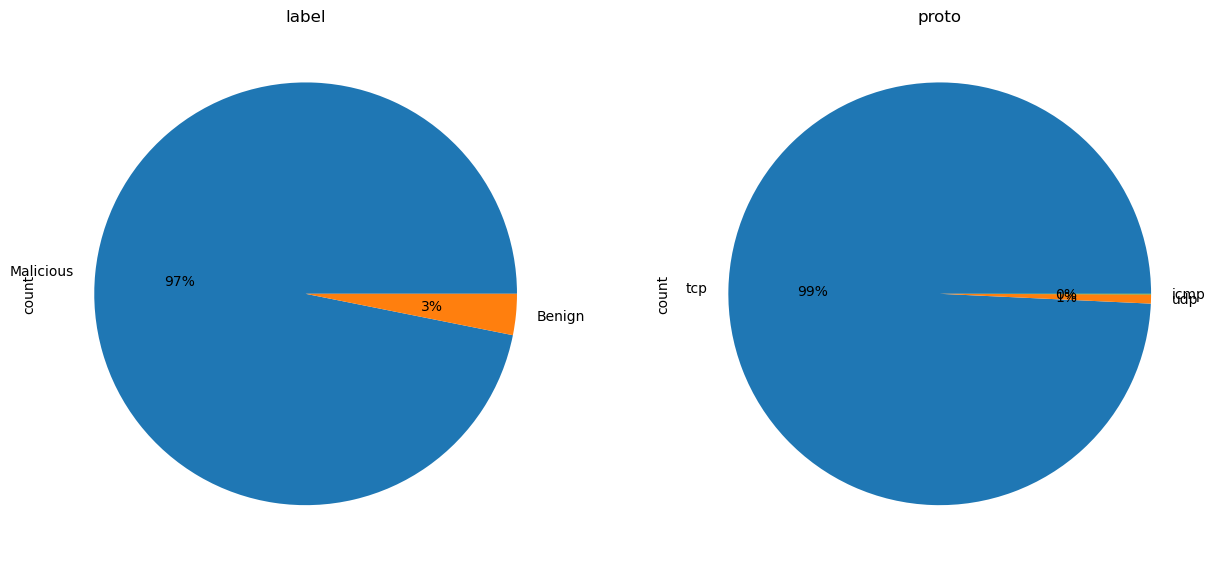

In [7]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
    

pie_plot(data_train, ["label", "proto"], 1, 2)

In [8]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df


def preprocess(dataframe):
    cat_cols = ["proto", "service", "conn_state", "history"]
    
    dataframe = dataframe.drop(columns=["ts", "uid", "id.orig_h", "id.resp_h", "id.orig_p", "id.resp_p", "tunnel_parents", "detailed-label"], errors='ignore')
    
    dataframe.replace('-', np.nan, inplace=True)
    
    numeric_cols = dataframe.columns.difference(cat_cols + ["label"])
    for col in numeric_cols:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    
    df_num = dataframe[numeric_cols]

    all_nan_cols = df_num.columns[df_num.isna().all()]
    if len(all_nan_cols) > 0:
        print(f"Columns with all NaN values: {all_nan_cols}")
        df_num[all_nan_cols] = 0  

    imputer = SimpleImputer(strategy='mean')
    imputed_values = imputer.fit_transform(df_num)

    df_num = pd.DataFrame(imputed_values, columns=numeric_cols, index=dataframe.index)

    scaled_df = Scaling(df_num, df_num.columns)

    dataframe[df_num.columns] = scaled_df.values
    
    dataframe["label"] = dataframe["label"].apply(lambda x: 0 if x == "Benign" else 1)
    
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
    
    return dataframe



In [9]:
scaled_train = preprocess(data_train)

#malicious_sample = scaled_train[scaled_train['label'] == 1].sample(5, random_state=42)
#normal_sample = scaled_train[scaled_train['label'] == 0].sample(5, random_state=42)

x = scaled_train.drop(['label'], axis=1, errors='ignore').values.astype('float32')
y = scaled_train['label'].values.astype('int')

print("Reached pca")

pca = PCA(n_components=20)
x_reduced = pca.fit_transform(x)

print("Here")

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

Columns with all NaN values: Index(['local_orig', 'local_resp'], dtype='object')
Reached pca
Here


In [11]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
def create_packet_classifier(input_shape, num_classes=1):
    """
    Creates an optimized deep learning model for network packet classification
    with improved architecture and regularization.
    
    Args:
        input_shape: Shape of input features
        num_classes: Number of output classes (default 1 for binary classification)
    """
    
    # Initialize regularization parameters
    reg_config = {
        'kernel': regularizers.L1L2(l1=1e-6, l2=1e-5),
        'bias': regularizers.L2(1e-5),
        'activity': regularizers.L2(1e-6)
    }
    
    model = tf.keras.Sequential([
        # Input layer with batch normalization
        layers.InputLayer(input_shape=input_shape),
        layers.BatchNormalization(),
        
        # First block - smaller layers for feature extraction
        layers.Dense(32, activation='relu',
                    kernel_regularizer=reg_config['kernel'],
                    bias_regularizer=reg_config['bias'],
                    activity_regularizer=reg_config['activity']),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Second block - moderate size for pattern recognition
        layers.Dense(64, activation='relu',
                    kernel_regularizer=reg_config['kernel'],
                    bias_regularizer=reg_config['bias'],
                    activity_regularizer=reg_config['activity']),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Third block - larger size for complex pattern learning
        layers.Dense(256, activation='relu',
                    kernel_regularizer=reg_config['kernel'],
                    bias_regularizer=reg_config['bias'],
                    activity_regularizer=reg_config['activity']),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

def train_model(model, x_train, y_train, x_val, y_val, batch_size=32, max_epochs=50):
    """
    Trains the model with optimized parameters and callbacks.
    """
    
    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when training plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Save best model with .keras extension
        ModelCheckpoint(
            'best_packet_classifier.keras',  # Changed from .h5 to .keras
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    
    # Compile model with optimized parameters
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0  # Gradient clipping to prevent exploding gradients
    )
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    # Train model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Example usage:
def preprocess_data(columns, data):
    """
    Preprocesses the network packet data.
    """
    # Convert categorical columns to numerical
    categorical_columns = ['proto', 'service', 'conn_state', 'history', 'tunnel_parents']
    numerical_columns = [col for col in columns if col not in categorical_columns + ['label', 'detailed-label']]
    
    # Normalize numerical features
    scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    
    # One-hot encode categorical features
    for col in categorical_columns:
        data = pd.get_dummies(data, columns=[col], prefix=col)
    
    return data


In [ ]:
input_shape = x_train.shape[1:]
print("Shaped")
model = create_packet_classifier(input_shape)
print("model")
history = train_model(model, x_train, y_train, x_test, y_test)

Shaped
model
Epoch 1/50
   5136/1476110 ━━━━━━━━━━━━━━━━━━━━ 1:58:42 5ms/step - accuracy: 0.9483 - auc: 0.6114 - loss: 0.1901 - precision: 0.9743 - recall: 0.9722

In [ ]:
with open('test3.log.labeled', 'r') as f:
    lines = f.readlines()
    
    with open('test3.log.labeled.csv', 'w') as ff:
        for line in lines[8:-1]:
            line = line.replace('\t', ',').replace('   ', ',')
            ff.write(line)        

In [ ]:
df = pd.read_csv('test3.log.labeled.csv')

columns = ["ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", 
          "proto", "service", "duration", "orig_bytes", "resp_bytes", 
          "conn_state", "local_orig", "local_resp", "missed_bytes", 
          "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", 
          "resp_ip_bytes", "tunnel_parents", "label", "detailed-label"]

df.columns = columns

required_columns = ["proto", "service", "conn_state", "history", "local_orig", 
                   "local_resp", "orig_bytes", "resp_bytes", "orig_ip_bytes", 
                   "resp_ip_bytes", "resp_pkts"]

for col in required_columns:
    if col not in df.columns:
        df[col] = np.nan

df_new = df.copy()

# Add history column with default value if missing
if 'history' not in df.columns:
    df['history'] = 'S'
    


# Add label column (will be dropped during preprocessing)
df['label'] = 'unknown'

# Preprocess the data using your existing preprocess function
preprocessed_data = preprocess(df)

# Ensure columns match training data
train_columns = scaled_train.drop('label', axis=1).columns
missing_cols = set(train_columns) - set(preprocessed_data.columns)
for col in missing_cols:
    preprocessed_data[col] = 0

# Reorder columns to match training data
preprocessed_data = preprocessed_data[train_columns]

# Convert to numpy array
x_new = preprocessed_data.values.astype('float32')

# Transform with PCA
x_new_reduced = pca.transform(x_new)

# Make predictions
predictions = model.predict(x_new_reduced)
predicted_outcomes = (predictions > 0.5).astype('int')

# Add predictions to original DataFrame
df['predicted_outcome'] = predicted_outcomes

# Calculate basic statistics
total_packets = len(predicted_outcomes)
malicious_packets = np.sum(predicted_outcomes)
normal_packets = total_packets - malicious_packets
malicious_percentage = (malicious_packets / total_packets) * 100

print("-"*55)

print("Prediction Summary:")
print(f"Total packets analyzed: {total_packets}")
print(f"Malicious packets detected: {malicious_packets} ({malicious_percentage:.2f}%)")
print(f"Normal packets detected: {normal_packets} ({100-malicious_percentage:.2f}%)")

print("-"*55)

# Actual summary
print("Summary of actual data")
print("Total packets: ", len(df_new))
print("Unique protocols: ", df_new['proto'].nunique())

malicious_packets = df_new['label'].value_counts()[0]
normal_packets = df_new['label'].value_counts()[1]
total_packets = len(df_new)
malicious_percentage = (malicious_packets / total_packets) * 100

print(" ")
# Print the statistics
print(f"Total packets analyzed: {total_packets}")
print(f"Malicious packets detected: {malicious_packets} ({malicious_percentage:.2f}%)")
print(f"Normal packets detected: {normal_packets} ({100-malicious_percentage:.2f}%)")

print("-"*55)

pie_plot(df_new, ["label", "proto"], 1, 2)


# Create time-based analysis
df['timestamp'] = pd.to_datetime(df['ts'], unit='s')
df['minute'] = df['timestamp'].dt.floor('T')

# Analyze predictions over time
temporal_analysis = df.groupby('minute').agg({
    'predicted_outcome': ['count', 'sum']
}).reset_index()
temporal_analysis.columns = ['minute', 'total_packets', 'malicious_packets']
temporal_analysis['normal_packets'] = temporal_analysis['total_packets'] - temporal_analysis['malicious_packets']
temporal_analysis['malicious_ratio'] = temporal_analysis['malicious_packets'] / temporal_analysis['total_packets']

# Visualize results
plt.style.use('default')
fig = plt.figure(figsize=(15, 10))

# Plot 1: Timeline of predictions
plt.subplot(2, 1, 1)
plt.plot(temporal_analysis['minute'], temporal_analysis['normal_packets'],
        label='Normal', color='#2ecc71', alpha=0.7, linewidth=2)
plt.plot(temporal_analysis['minute'], temporal_analysis['malicious_packets'],
        label='Malicious', color='#e74c3c', alpha=0.7, linewidth=2)
plt.title('Packet Classification Over Time', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Number of Packets', fontsize=10)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Malicious ratio over time
plt.subplot(2, 1, 2)
plt.plot(temporal_analysis['minute'], temporal_analysis['malicious_ratio'],
        color='#9b59b6', alpha=0.7, linewidth=2)
plt.title('Ratio of Malicious Packets Over Time', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=10)
plt.ylabel('Ratio of Malicious Packets', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Save results
os.makedirs('data', exist_ok=True)
df.to_csv('data/predicted_new_data.csv', index=False)
temporal_analysis.to_csv('data/temporal_analysis.csv', index=False)

# Save summary statistics
summary_stats = {
    'total_packets': total_packets,
    'malicious_packets': int(malicious_packets),
    'normal_packets': int(normal_packets),
    'malicious_percentage': float(malicious_percentage),
    'analysis_timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'available_features': df.columns.tolist()
}

with open('data/verification_results.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print("\nResults saved to 'data' directory")

In [ ]:

def clean_duration(x):
    """Clean duration values by handling various formats and invalid values"""
    if pd.isna(x) or x == '-' or str(x).strip() == '':
        return pd.NaT
    try:
        return float(x)
    except (ValueError, TypeError):
        return pd.NaT

def create_timeline_plots(temporal_analysis):
    """
    Create timeline visualizations of the network traffic with improved error handling
    and date formatting
    """
    try:
        # Convert minute column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(temporal_analysis['minute']):
            temporal_analysis['minute'] = pd.to_datetime(temporal_analysis['minute'])

        # Sort by time to ensure proper plotting
        temporal_analysis = temporal_analysis.sort_values('minute')

        # Create figure and axes objects explicitly
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Plot 1: Timeline of predictions
        ax1.plot(temporal_analysis['minute'], temporal_analysis['normal_packets'],
                label='Normal', color='#2ecc71', alpha=0.7, linewidth=2)
        ax1.plot(temporal_analysis['minute'], temporal_analysis['malicious_packets'],
                label='Malicious', color='#e74c3c', alpha=0.7, linewidth=2)
        ax1.set_title('Packet Classification Over Time', pad=20, fontsize=12, fontweight='bold')
        ax1.set_xlabel('Time', fontsize=10)
        ax1.set_ylabel('Number of Packets', fontsize=10)
        ax1.legend(frameon=True, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Rotate x-axis labels for better readability
        ax1.tick_params(axis='x', rotation=45)

        # Plot 2: Malicious ratio over time
        ax2.plot(temporal_analysis['minute'], temporal_analysis['malicious_ratio'],
                color='#9b59b6', alpha=0.7, linewidth=2)
        ax2.set_title('Ratio of Malicious Packets Over Time', pad=20, fontsize=12, fontweight='bold')
        ax2.set_xlabel('Time', fontsize=10)
        ax2.set_ylabel('Ratio of Malicious Packets', fontsize=10)
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        # Rotate x-axis labels for better readability
        ax2.tick_params(axis='x', rotation=45)

        # Adjust layout to prevent label cutoff
        plt.tight_layout()
         
        # Show the plot
        plt.show()
        
        # Close the figure to free up memory
        plt.close(fig)

    except Exception as e:
        print(f"Error creating timeline plots: {str(e)}")
        print("Debug information:")
        print(f"Temporal analysis columns: {temporal_analysis.columns.tolist()}")
        print(f"Minute column dtype: {temporal_analysis['minute'].dtype}")
        print("\nFirst few rows of temporal analysis data:")
        print(temporal_analysis.head())

def create_protocol_plot(protocol_analysis):
    """Create protocol distribution visualization with improved error handling"""
    try:
        plt.figure(figsize=(12, 6))
        
        # Create bar plot
        ax = protocol_analysis[['normal_packets', 'malicious_packets']].plot(
            kind='bar',
            stacked=True,
            color=['#2ecc71', '#e74c3c']
        )
        
        # Customize plot
        plt.title('Packet Distribution by Protocol', fontsize=12, fontweight='bold')
        plt.xlabel('Protocol', fontsize=10)
        plt.ylabel('Number of Packets', fontsize=10)
        plt.legend(['Normal', 'Malicious'], frameon=True, fancybox=True, shadow=True)
        
        # Rotate x-axis labels and adjust their position
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on the bars
        for c in ax.containers:
            ax.bar_label(c, fmt='%.0f', label_type='center')

        # Add grid to y-axis
        plt.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
        # Close the figure to free up memory
        plt.close()

    except Exception as e:
        print(f"Error creating protocol plot: {str(e)}")
        print("Debug information:")
        print(f"Protocol analysis columns: {protocol_analysis.columns.tolist()}")
        print("\nFirst few rows of protocol analysis data:")
        print(protocol_analysis.head())

def analyze_network_traffic(df):
    """Analyze network traffic data and generate visualizations and statistics"""
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Calculate basic statistics about predictions
    total_packets = len(df)
    predicted_outcomes = df['predicted_outcome'].values
    malicious_packets = np.sum(predicted_outcomes)
    normal_packets = total_packets - malicious_packets
    malicious_percentage = (malicious_packets / total_packets) * 100

    print("Prediction Summary:")
    print(f"Total packets analyzed: {total_packets}")
    print(f"Normal packets detected: {normal_packets} ({100-malicious_percentage:.2f}%)")
    print(f"Malicious packets detected: {malicious_packets} ({malicious_percentage:.2f}%)")
    print("\n")

    # Create time-based analysis with error handling
    temporal_analysis = None
    try:
        if 'duration' in df.columns:
            # Clean duration values
            df['clean_duration'] = df['duration'].apply(clean_duration)
            
            # Count and report invalid duration values
            invalid_count = df['clean_duration'].isna().sum()
            if invalid_count > 0:
                print(f"Warning: Found {invalid_count} invalid duration values")
            
            # Create timestamp for valid duration values
            df['timestamp'] = pd.to_datetime(
                df['clean_duration'].apply(
                    lambda x: datetime.fromtimestamp(x) if pd.notnull(x) else pd.NaT
                )
            )
            
            # Only proceed with temporal analysis if we have valid timestamps
            valid_timestamps = df['timestamp'].notna()
            if valid_timestamps.any():
                df['minute'] = df['timestamp'].dt.floor('T')
                
                # Analyze predictions over time (using only valid timestamps)
                temporal_analysis = df[valid_timestamps].groupby('minute').agg({
                    'predicted_outcome': ['count', 'sum']
                }).reset_index()
                temporal_analysis.columns = ['minute', 'total_packets', 'malicious_packets']
                temporal_analysis['normal_packets'] = temporal_analysis['total_packets'] - temporal_analysis['malicious_packets']
                temporal_analysis['malicious_ratio'] = temporal_analysis['malicious_packets'] / temporal_analysis['total_packets']

                print(f"\nTemporal analysis completed using {valid_timestamps.sum()} valid timestamps")
                
                # Create visualizations only if we have enough data points
                if len(temporal_analysis) > 1:
                    create_timeline_plots(temporal_analysis)
                else:
                    print("Warning: Not enough valid timestamps for temporal visualization")
            else:
                print("Warning: No valid timestamps found for temporal analysis")
        else:
            print("Warning: No 'duration' column found in the dataset")
            
    except Exception as e:
        print(f"Warning: Could not perform temporal analysis: {str(e)}")

    # Protocol analysis
    if 'protocol_type' in df.columns:
        try:
            protocol_analysis = df.groupby('protocol_type').agg({
                'predicted_outcome': ['count', 'sum', 'mean']
            })
            protocol_analysis.columns = ['total_packets', 'malicious_packets', 'malicious_ratio']
            protocol_analysis['normal_packets'] = protocol_analysis['total_packets'] - protocol_analysis['malicious_packets']
            
            print("\nProtocol-based Analysis:")
            print(protocol_analysis.round(4))
            
            create_protocol_plot(protocol_analysis)
            
        except Exception as e:
            print(f"Warning: Could not complete protocol analysis: {str(e)}")

    # Packet size analysis with improved error handling
    analyze_packet_sizes(df)

    # Anomaly detection
    if temporal_analysis is not None:
        detect_anomalies(temporal_analysis)

    # Generate and save summary
    save_results(df, total_packets, malicious_packets, normal_packets, 
                malicious_percentage, temporal_analysis)

def analyze_packet_sizes(df):
    """Analyze packet sizes for normal and malicious traffic"""
    for size_col in ['src_bytes', 'dst_bytes']:
        if size_col in df.columns:
            try:
                # Clean the byte values first
                df[f'clean_{size_col}'] = pd.to_numeric(df[size_col], errors='coerce')
                normal_mean = df[df['predicted_outcome'] == 0][f'clean_{size_col}'].mean()
                malicious_mean = df[df['predicted_outcome'] == 1][f'clean_{size_col}'].mean()
                
                print(f"\n{size_col.replace('_', ' ').title()} Analysis:")
                print(f"Average size of normal packets: {normal_mean:.2f}")
                print(f"Average size of malicious packets: {malicious_mean:.2f}")
            except Exception as e:
                print(f"Warning: Could not analyze {size_col}: {str(e)}")

def detect_anomalies(temporal_analysis):
    """Detect potential anomalies in the traffic patterns"""
    print("\nPotential Anomalies:")
    try:
        spike_threshold = temporal_analysis['malicious_ratio'].mean() + 2 * temporal_analysis['malicious_ratio'].std()
        spikes = temporal_analysis[temporal_analysis['malicious_ratio'] > spike_threshold]
        if not spikes.empty:
            print(f"Found {len(spikes)} time periods with unusual spikes in malicious traffic:")
            for _, spike in spikes.iterrows():
                print(f"Time: {spike['minute']}, Malicious ratio: {spike['malicious_ratio']:.2%}")
        else:
            print("No significant spikes in malicious traffic detected.")
    except Exception as e:
        print(f"Warning: Could not complete anomaly detection: {str(e)}")

def save_results(df, total_packets, malicious_packets, normal_packets, 
                malicious_percentage, temporal_analysis):
    """Save analysis results to files"""
    summary_stats = {
        'total_packets': total_packets,
        'malicious_packets': int(malicious_packets),
        'normal_packets': int(normal_packets),
        'malicious_percentage': float(malicious_percentage),
        'analysis_timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'available_features': df.columns.tolist()
    }

    if 'clean_duration' in df.columns:
        valid_durations = df['clean_duration'].dropna()
        if not valid_durations.empty:
            summary_stats['total_duration_seconds'] = float(valid_durations.max() - valid_durations.min())
            summary_stats['valid_duration_count'] = len(valid_durations)
            summary_stats['invalid_duration_count'] = len(df) - len(valid_durations)

    try:
        os.makedirs('data', exist_ok=True)
        
        with open('data/verification_results.json', 'w') as f:
            json.dump(summary_stats, f, indent=4)
        print("\nVerification results saved to 'data/verification_results.json'")
        
        if temporal_analysis is not None:
            temporal_analysis.to_csv('data/temporal_analysis.csv', index=False)
            print("Temporal analysis saved to 'data/temporal_analysis.csv'")
        
    except Exception as e:
        print(f"Warning: Error saving results: {str(e)}")